*Author: C Mitchell*

This notebook is a round-up of the various different partial least squares analyses for estimating *the log scaled* biomass (wet weight) of fucus and asco. It contains results for:

1. The hyperspectral reflectance data for
    - Both asco and fucus combined
    - Asco only
    - Fucus only
2. The multispectral reflectance data (the hyperspectral data downsampled to the drone wavelengths) for
    - Both asco and fucus combined
    - Asco only
    - Fucus only

# Initialization

Importing the libraries and the data

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from scipy.special import logit
import warnings

%matplotlib inline

In [22]:
msldf = pd.read_csv('../data/spectral_library_multi.csv')
hsldf = pd.read_csv('../data/spectral_library.csv')
metadf = pd.read_csv('../data/sample_list_v3.csv')

Extracting only the data with a wavelength of less than 1800 nm

In [29]:
hsldf = hsldf.loc[hsldf.Wvl <= 1800]

### Logit transformation

In [30]:
def normalise(x):
    return x/100

In [31]:
lmsldf = msldf.drop('Wvl',axis=1).apply(normalise,axis=1).apply(logit,axis=1)
lmsldf['Wvl'] = msldf['Wvl']

lhsldf = hsldf.drop('Wvl',axis=1).apply(normalise,axis=1).apply(logit,axis=1)
lhsldf['Wvl'] = hsldf['Wvl']

## Defining functions

In [32]:
def datawrangle(sldf,metadf,regex,target):
    '''create x and y variables for PLS where
    sldf = spectral library dataframe with all data
    metadf = metadata dataframe
    regex = regex as a string for which columns to filter on
    e.g. "ucus\d*\w*_mean"
    target = column name from metadf that is being predicted e.g. wet_weight'''
    
    meandf = sldf.filter(regex = regex)
    meandf = meandf.rename(columns=lambda x: re.sub('_mean','',x))
    
    X1 = meandf.dropna().T
    X1.index.name = 'idkey'
    y1 = metadf
    combineddf = X1.merge(y1,on='idkey')
    
    y = np.log10(combineddf[target].values)
    X = combineddf.filter(regex = '[0-9]').values
    
    return X,y

In [33]:
def plscalc(X,y):
    warnings.filterwarnings('ignore')
    
    #define cross-validation method
    cv = model_selection.LeaveOneOut()

    #making pipeline
    mses = []
    for n_comps in np.arange(1,11):
        pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=n_comps))
        score = -1*model_selection.cross_val_score(pls, X, y, cv=cv, scoring = 'neg_mean_squared_error')
        val = score.mean()
        mses += [val]     

    #finding number of components
    idx = np.argmin(mses)

    # predictions
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

    #pls
    pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=idx+1))
    pls.fit(X_train, y_train)
    
    return X_train,X_test,y_train,y_test,pls

In [34]:
def plsstats(pls,X,y):
    performancestats = {'rmse' : np.sqrt(mean_squared_error(y, pls.predict(X))),
    'mae' : mean_absolute_error(y, pls.predict(X)),
    'r2' : pls.score(X,y)}
    
    return performancestats

In [39]:
def plsplot(pls,X,y):
    plt.figure()
    plt.plot(y, pls.predict(X),'.')
    plt.plot(y,y,'-',label = 'expected')
    z = np.polyfit(y, pls.predict(X),1)
    plt.plot(y,np.polyval(z,y),'-',label='predicted')
    plt.xlabel('lab measured log10(biomass) (g)')
    plt.ylabel('predicted log10(biomass) from hyperspectral reflectance (g)')
    plt.legend()

# PLS Analysis

In the following sections, I create a model for biomass from reflectance for both asco and fucus combined, for asco only and for fucus only. In each case, I split the dataset 70% for training, 30% of testing.

For each model there's two graphs plotted:
1. The test results
2. The training dataset

The performance of all the models is given after all the graphs (in the Stats Summary subsection).

In [40]:
species = {'asco' : 'sco\d*\w*_mean', 'fucus' : 'ucus\d*\w*_mean','both' : '_mean'}
res = {'hyper' : hsldf, 'multi' : msldf,
      'hyper_logit' : lhsldf, 'multi_logit' : lmsldf}

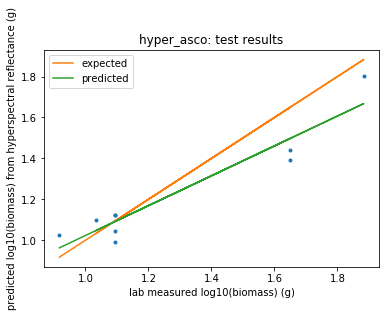

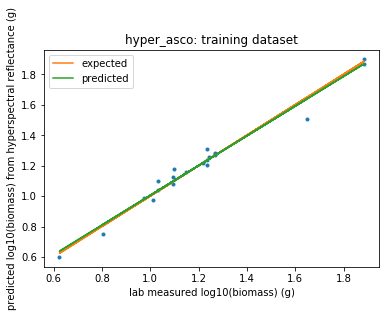

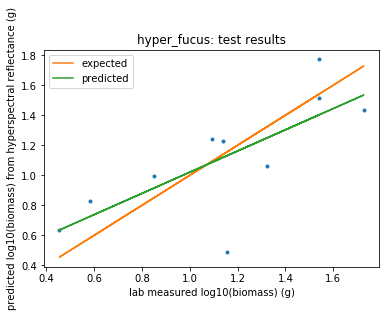

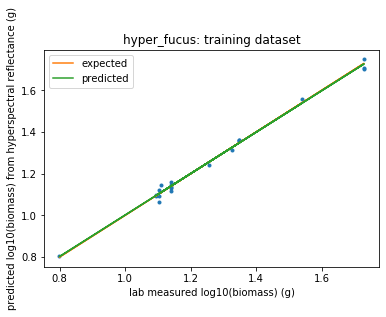

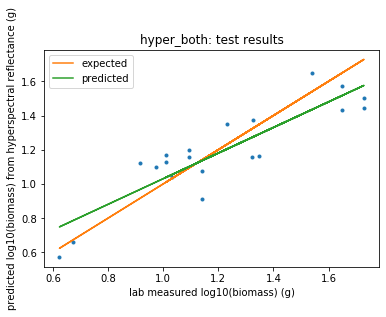

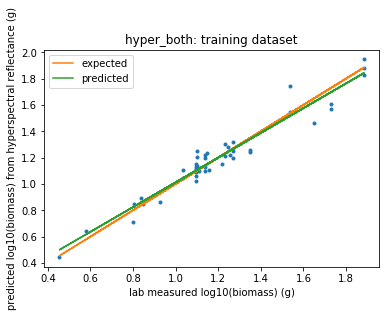

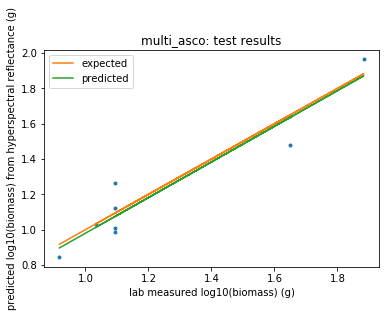

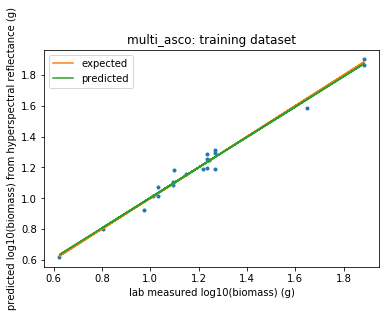

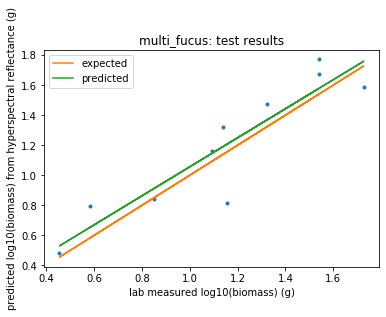

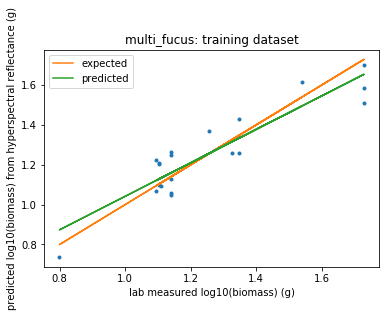

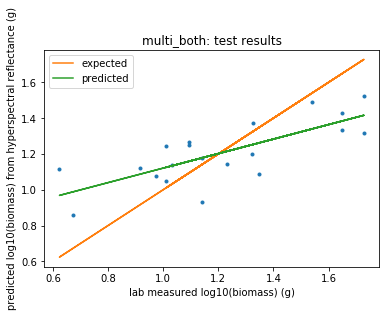

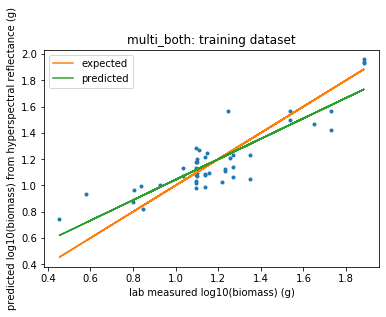

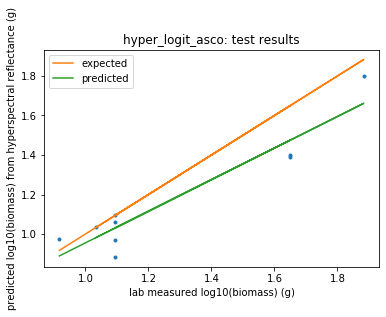

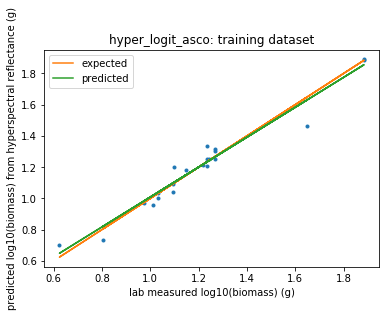

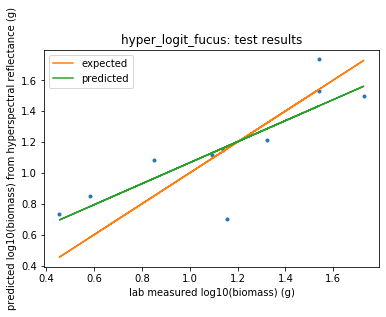

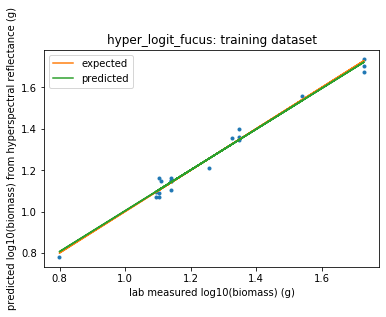

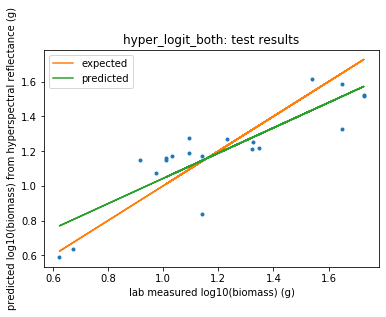

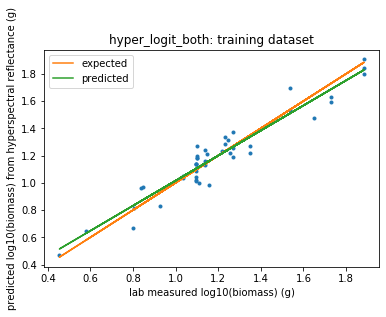

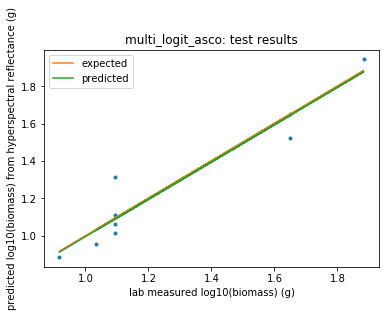

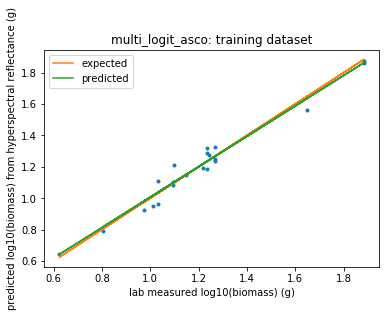

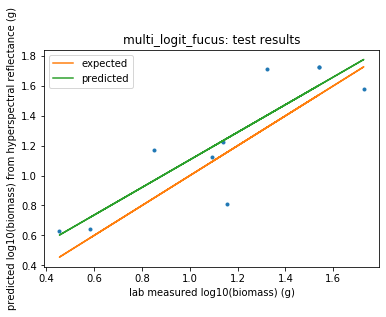

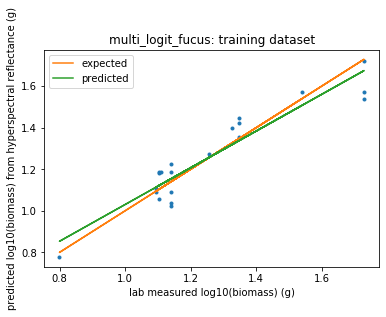

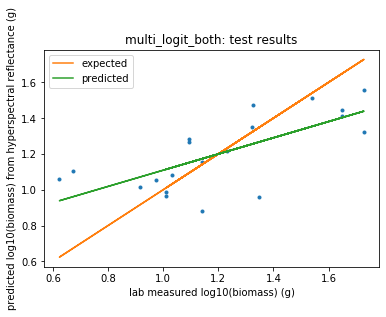

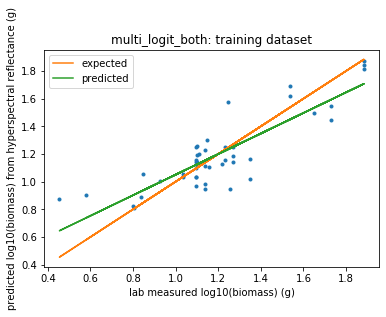

In [41]:
performancestats = {}
for rkey,rvalue in res.items():
    for spkey,spvalue in species.items():
        X,y = datawrangle(rvalue,metadf,spvalue,'wet_weight_sensed')
        X_train,X_test,y_train,y_test,pls = plscalc(X,y)
        performancestats[rkey+'_'+spkey] = plsstats(pls,X_test,y_test)
        
        plsplot(pls,X_test,y_test)
        plt.title(rkey+'_'+spkey+': test results');
        
        plsplot(pls,X_train,y_train)
        plt.title(rkey+'_'+spkey+': training dataset');

# Stats Summary

In [42]:
pd.DataFrame(performancestats).T

,rmse,mae,r2
hyper_asco,0.128235,0.103682,0.847187
hyper_fucus,0.283038,0.229117,0.488750
hyper_both,0.148811,0.128233,0.778369
multi_asco,0.099380,0.080236,0.908221
multi_fucus,0.176768,0.149510,0.800587
multi_both,0.217595,0.182994,0.526130
hyper_logit_asco,0.150065,0.114136,0.790731
hyper_logit_fucus,0.226862,0.181387,0.671550
hyper_logit_both,0.157425,0.133476,0.751968
multi_logit_asco,0.095649,0.071558,0.914982
